# Classifying Planets: Exploring Habitability

## Introduction

In the vast expanse of the cosmos, the search for habitable planets has captivated the imaginations of scientists and explorers alike. As humanity reaches for the stars, our quest to understand the conditions necessary for life beyond Earth has led us to a fascinating challenge: predicting the habitability of distant planets.

In this classification problem, we embark on a journey where we are presented with a synthetic dataset, carefully crafted to simulate various planetary features. Our mission is clear: **discern whether a planet is habitable or deemed inhospitable to life**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load the data

In [2]:
data_df = pd.read_csv("data/data.csv")

## Exploring the data

### Data Field Descriptions

- **planet_habitability.csv** - Synthetic dataset containing planetary features and their corresponding habitability classification. (10'000 per class)

| Feature                              | Description                                                              |
| ------------------------------------ | ------------------------------------------------------------------------ |
| `Atmospheric Pressure (bar)`         | Average pressure of the planet's atmosphere                              |
| `Magnetic Field Strength (µT)`       | Strength of the planet's magnetic field                                  |
| `H2O Traces`                         | Presence of water on the planet                                          |
| `Average Radiation Levels (Siverts)` | Average amount of radiation the planet is exposed to per year            |
| `Alien Presence Probability`         | Probability of alien life on the planet                                  |
| `Solar Flare Frequency (per year)`   | Frequency of solar flares on the planet per year                         |
| `Bio-Growth Probability`             | Potential of the planet to support life                                  |
| `Habitability`                       | Habitability classification, 0 being non-habitable and 1 being habitable |

In [3]:
data_df.head()

,Atmospheric Pressure (bar),Magnetic Field Strength (µT),H2O Traces,Average Radiation Levels (Siverts),Alien Presence Probability,Solar Flare Frequency (per year),Bio-Growth Probability,Habitability
0,1.954338,0.109793,1,0.374889,0.069769,4.099807,1.026868,0
1,1.316607,1.802344,1,1.216051,0.003249,32.232770,0.936547,0
2,2.216222,2.149550,1,0.127412,0.146589,25.145592,1.276934,0
3,1.202366,1.819107,1,0.252355,0.177635,26.807007,1.031786,0
4,0.736884,1.303888,1,0.351282,0.016050,12.618122,0.343656,0


In [4]:
print('Data shape:', data_df.shape)

data_df.describe(include='all')

Data shape: (20000, 8)


,Atmospheric Pressure (bar),Magnetic Field Strength (µT),H2O Traces,Average Radiation Levels (Siverts),Alien Presence Probability,Solar Flare Frequency (per year),Bio-Growth Probability,Habitability
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.558239,1.854794,0.819250,0.670246,0.267720,18.396085,0.628849,0.500000
std,0.721302,0.985545,0.384821,0.382781,0.143557,10.527343,0.315787,0.500013
min,0.100492,0.010480,0.000000,0.010057,0.000035,0.002061,0.000125,0.000000
25%,0.980152,1.104998,1.000000,0.358444,0.147765,9.606472,0.380197,0.000000
50%,1.581927,1.850455,1.000000,0.660018,0.275767,18.315122,0.650800,0.500000
75%,2.125757,2.442629,1.000000,0.935853,0.393014,26.676469,0.873705,1.000000
max,2.999982,3.999685,1.000000,1.499739,0.499989,39.998752,1.493963,1.000000


## Visualizing the data

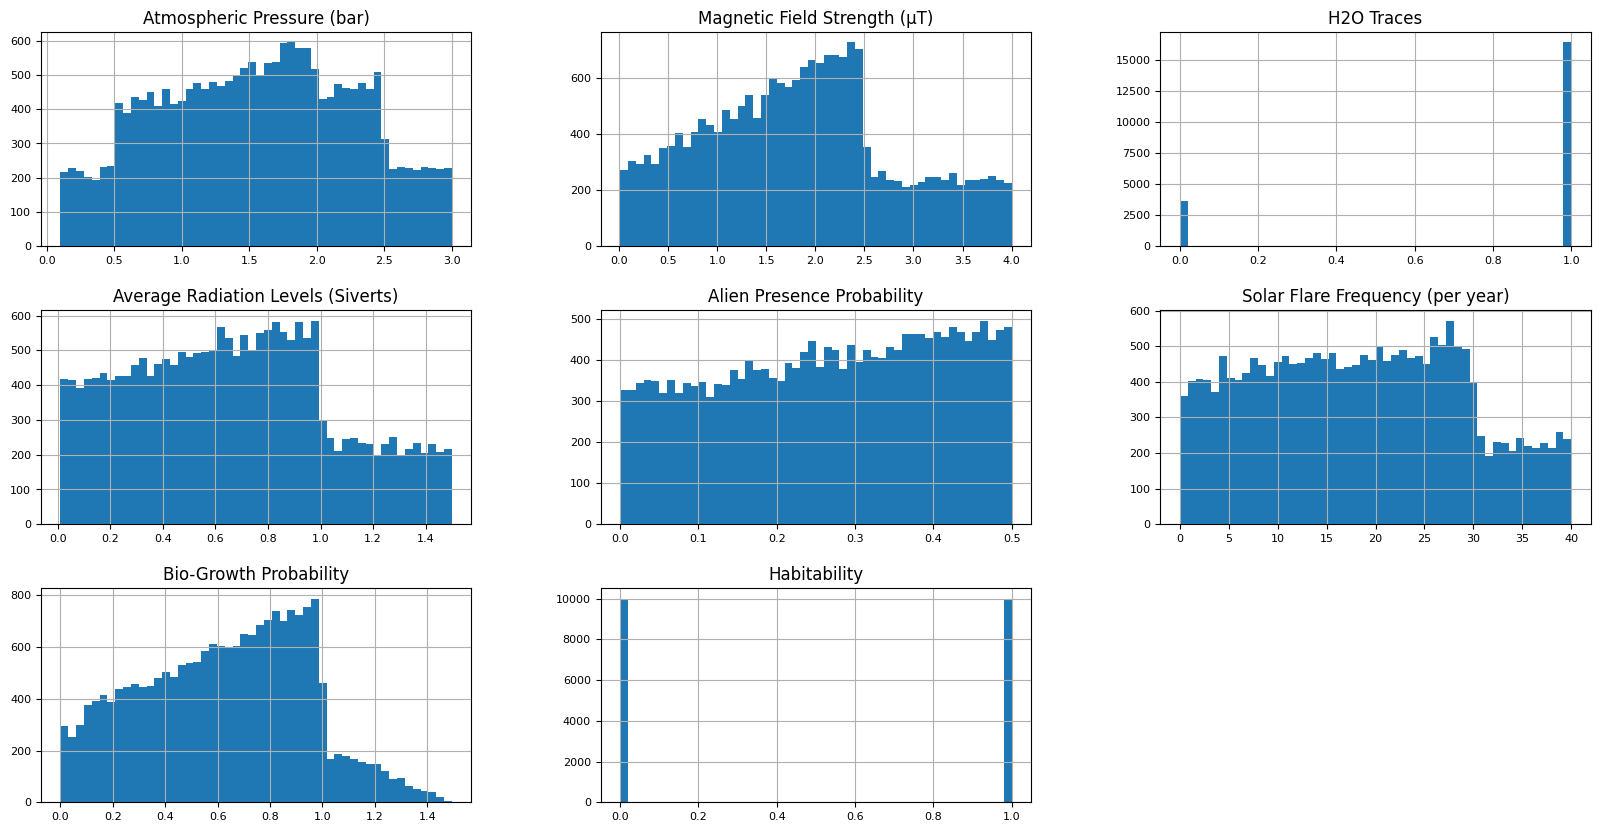

In [5]:
# Plot all features
data_df.hist(figsize=(20, 10), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

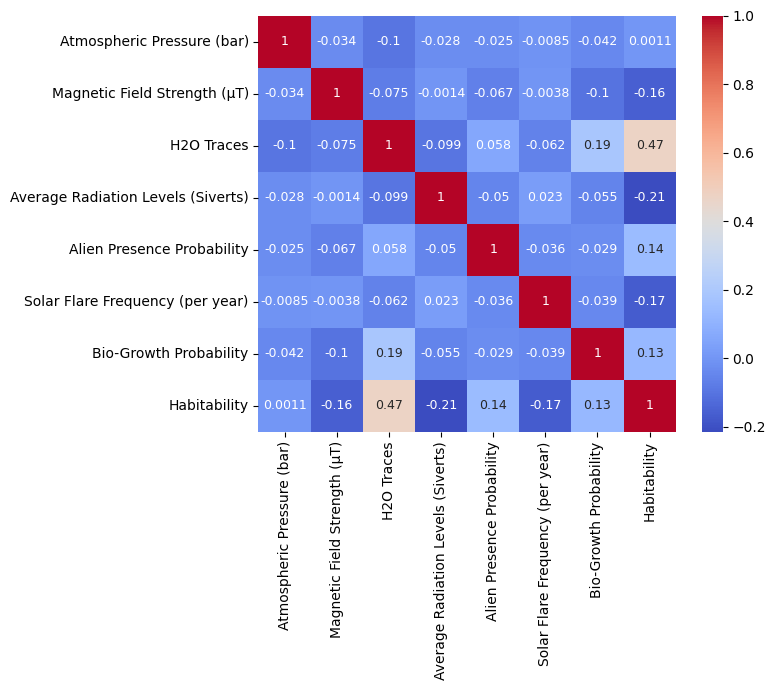

In [6]:
# Plot confusion matrix with plt and df.corr
plt.figure(figsize=(8, 7), tight_layout=True)
sns.heatmap(data_df.corr(), annot=True, annot_kws={"size": 9}, cmap="coolwarm")
plt.show()

## Preparing the data

The following steps are performed to prepare the data:

- Normalizing the data
- Shuffling the data
- Splitting the data into training and validation sets

In [7]:
# Normalize each feature to a range of [0, 1] except the target feature
normalized_df = data_df.copy()

for feature in set(data_df.columns) - set(["Habitability"]):
    normalized_df[feature] = (data_df[feature] - data_df[feature].min()) / (
            data_df[feature].max() - data_df[feature].min()
    )

# Shuffle the dataset
normalized_df = normalized_df.sample(frac=1).reset_index(drop=True)

normalized_df.head()

,Atmospheric Pressure (bar),Magnetic Field Strength (µT),H2O Traces,Average Radiation Levels (Siverts),Alien Presence Probability,Solar Flare Frequency (per year),Bio-Growth Probability,Habitability
0,0.811898,0.516362,1.0,0.655949,0.998964,0.040823,0.558741,1
1,0.544356,0.144808,1.0,0.971745,0.457650,0.232911,0.292472,1
2,0.435478,0.016679,1.0,0.369508,0.388674,0.178685,0.876495,0
3,0.803091,0.345777,1.0,0.531639,0.520319,0.472197,0.503190,1
4,0.171661,0.909513,1.0,0.512265,0.929934,0.334609,0.653872,1


In [8]:
# Split the dataset into features and labels
X = normalized_df.drop(["Habitability"], axis=1).values
y = normalized_df["Habitability"].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (14000, 7) (14000,)
Test set shape: (6000, 7) (6000,)


## Training the model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [10]:
# Train the model
model = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=1)

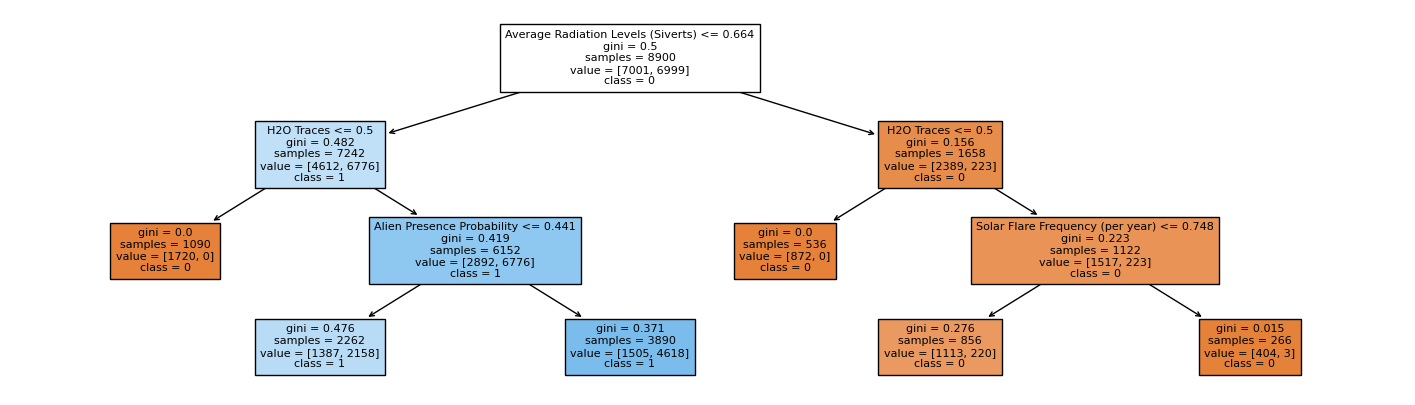

In [11]:
# Visualize the decision tree
plt.figure(figsize=(18, 5))
plot_tree(model.estimators_[0], feature_names=data_df.columns, class_names=["0", "1", "2"], filled=True, fontsize=8)
plt.show()

## Model Evaluation

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

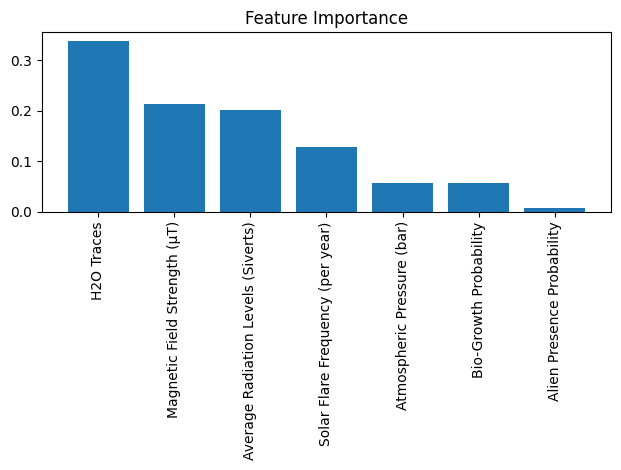

In [13]:
# Calculate feature importances
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [normalized_df.columns[i] for i in indices]

# Create plot
plt.figure(tight_layout=True)
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

Test Accuracy: 85.83%
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      2986
           1       0.84      0.88      0.86      3014

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



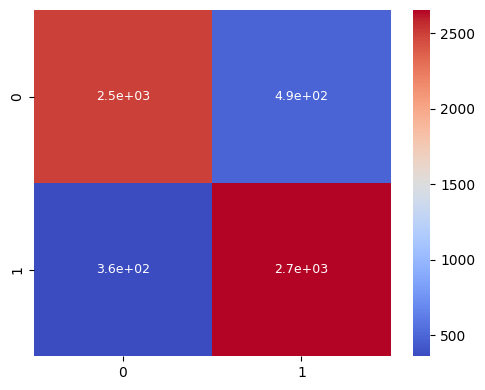

In [14]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4), tight_layout=True)
sns.heatmap(cm, annot=True, annot_kws={"size": 9}, cmap="coolwarm")
plt.show()